In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineCosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT

In [3]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.tensor([10000.0], device="cuda")) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device="cuda"))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)

In [4]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.input = nn.Linear(2, emb_size)
        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, time_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, time_emb, scale=25.0)

        layers = [nn.Linear(emb_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        # x1_emb = self.input_mlp1(x[:, 0])
        # x2_emb = self.input_mlp2(x[:, 1])

        # print(x1_emb.shape, x2_emb.shape)

        t_emb = self.time_mlp(t)
        x = self.input(x)
        # print(t_emb.shape)

        # x = x1_emb + x2_emb + t_emb
        # print(x.shape)

        x = x + t_emb.unsqueeze(1)
        x = self.joint_mlp(x)

        # print("asdf")
        return x

In [5]:
dataset = SineCosineDataset(type="sine", num_points=10)
dataloader = DataLoader(dataset, collate_fn=dataset.collate, batch_size=128)

In [7]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=250, learn_sigma=False)
# dit = UnconditionalPointCloudDiT(input_size=32, in_channels=2, depth=1, num_heads=1, hidden_size=128)
dit = MLP(hidden_size=128, hidden_layers=10, emb_size=128).to("cuda")
ddpm = PointCloudDDPM(dit, diffusion)

In [8]:
x = torch.randn(1, 64, 2, device="cuda")
t = torch.tensor([1], device="cuda")
dit(x, t).shape

torch.Size([1, 64, 2])

In [9]:
count_parameters(dit)

182274

In [10]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=10000 * 2,
    lr=1e-3
)

In [11]:
losses = trainer.train()
plt.plot(losses)

  0%|          | 1/20000 [00:00<42:50,  7.78it/s, loss=1.17]

 88%|████████▊ | 17607/20000 [01:07<00:09, 259.92it/s, loss=0.163]


KeyboardInterrupt: 

Sampling:  44%|████▎     | 109/250 [00:00<00:00, 1085.99it/s]

Sampling: 100%|██████████| 250/250 [00:00<00:00, 1079.61it/s]


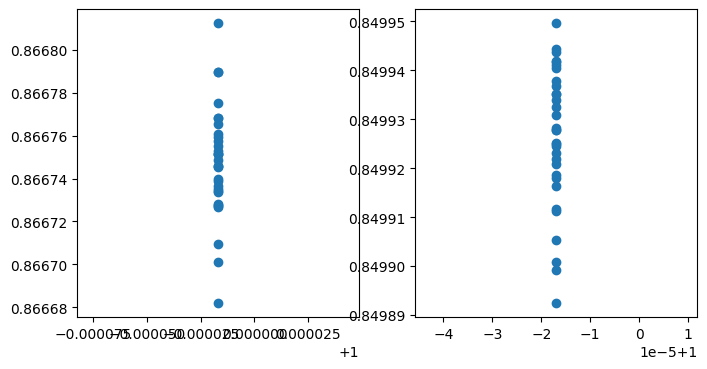

In [14]:
sample = diffusion.p_sample_loop(dit, (2, 32, 2))
plot_point_clouds(sample, 1, 2)

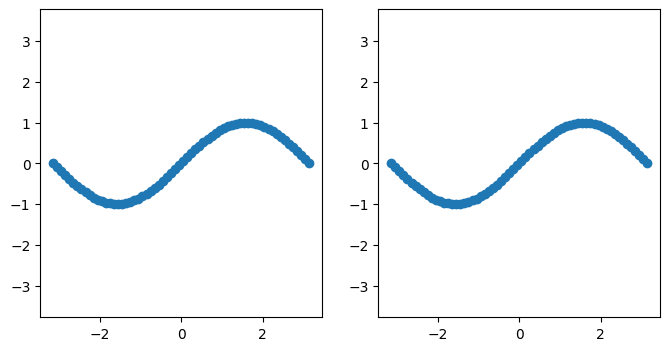

In [ ]:
plot_point_clouds(batch["data"], 1, 2)